# Hybrid D-MPNN + Descriptors for Melting Point Prediction

This notebook implements a **hybrid approach** combining:
1. **D-MPNN (Graph Neural Network)** - learns molecular representations from SMILES
2. **Hand-crafted descriptors** - 1326 features (424 Group + 20 RDKit + 882 Mordred)
3. **SMILES augmentation** - generates multiple SMILES variants per molecule
4. **Stacking ensemble** - combines GNN, XGBoost, and LightGBM predictions

**Baseline to beat:** XGBoost with RMSE=43.50, R²=0.739

**Expected performance:** R² = 0.78-0.82, RMSE = 36-40

## 1. Imports and Setup

In [16]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

# Mordred
from mordred import Calculator, descriptors as mordred_descriptors

# PyTorch
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Chemprop
import chemprop
print(f"Chemprop version: {chemprop.__version__}")

from chemprop.data import MoleculeDatapoint, MoleculeDataset, build_dataloader
from chemprop.featurizers import SimpleMoleculeMolGraphFeaturizer
from chemprop.nn import BondMessagePassing, MeanAggregation, RegressionFFN
from chemprop.models import MPNN

import lightning.pytorch as pl

# Sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV

# Tree models for ensemble
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

print("\nAll imports successful!")

PyTorch version: 2.9.1+cpu
CUDA available: False
Using device: cpu
Chemprop version: 2.2.2

All imports successful!


In [17]:
# Set random seeds
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

## 2. Load Data

In [18]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nTarget (Tm) statistics:")
print(train_df['Tm'].describe())

Training samples: 2662
Test samples: 666

Target (Tm) statistics:
count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64


## 3. Compute All Molecular Descriptors

Combining:
- 424 Group features (pre-computed in dataset)
- 20 RDKit descriptors
- 882 Mordred descriptors
- **Total: 1326 features**

In [19]:
def compute_rdkit_descriptors(smiles_list):
    """Compute RDKit descriptors"""
    descriptors_list = []
    
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            descriptors_list.append({key: np.nan for key in [
                'MolWt', 'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
                'NumRotatableBonds', 'NumAromaticRings', 'NumHeavyAtoms',
                'FractionCSP3', 'NumRings', 'NumHeteroatoms', 'MolMR',
                'NumValenceElectrons', 'NumRadicalElectrons', 'HallKierAlpha',
                'NumAliphaticRings', 'NumSaturatedRings', 'NumAromaticHeterocycles',
                'NumAliphaticHeterocycles', 'NumSaturatedHeterocycles'
            ]})
            continue
            
        desc = {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumHDonors': Lipinski.NumHDonors(mol),
            'NumHAcceptors': Lipinski.NumHAcceptors(mol),
            'NumRotatableBonds': Lipinski.NumRotatableBonds(mol),
            'NumAromaticRings': rdMolDescriptors.CalcNumAromaticRings(mol),
            'NumHeavyAtoms': Lipinski.HeavyAtomCount(mol),
            'FractionCSP3': rdMolDescriptors.CalcFractionCSP3(mol),
            'NumRings': rdMolDescriptors.CalcNumRings(mol),
            'NumHeteroatoms': rdMolDescriptors.CalcNumHeteroatoms(mol),
            'MolMR': Descriptors.MolMR(mol),
            'NumValenceElectrons': Descriptors.NumValenceElectrons(mol),
            'NumRadicalElectrons': Descriptors.NumRadicalElectrons(mol),
            'HallKierAlpha': Descriptors.HallKierAlpha(mol),
            'NumAliphaticRings': rdMolDescriptors.CalcNumAliphaticRings(mol),
            'NumSaturatedRings': rdMolDescriptors.CalcNumSaturatedRings(mol),
            'NumAromaticHeterocycles': rdMolDescriptors.CalcNumAromaticHeterocycles(mol),
            'NumAliphaticHeterocycles': rdMolDescriptors.CalcNumAliphaticHeterocycles(mol),
            'NumSaturatedHeterocycles': rdMolDescriptors.CalcNumSaturatedHeterocycles(mol),
        }
        descriptors_list.append(desc)
    
    return pd.DataFrame(descriptors_list)

print("Computing RDKit descriptors...")
train_rdkit = compute_rdkit_descriptors(train_df['SMILES'].values)
test_rdkit = compute_rdkit_descriptors(test_df['SMILES'].values)
print(f"  RDKit descriptors: {train_rdkit.shape[1]}")

Computing RDKit descriptors...
  RDKit descriptors: 20


In [20]:
def compute_mordred_descriptors(smiles_list):
    """Compute Mordred descriptors that work for all molecules"""
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    
    calc = Calculator(mordred_descriptors, ignore_3D=True)
    print(f"  Calculating {len(calc.descriptors)} Mordred descriptors...")
    df = calc.pandas(mols)
    
    df = df.apply(pd.to_numeric, errors='coerce')
    valid_cols = df.columns[df.notna().all()].tolist()
    df_clean = df[valid_cols]
    df_clean = df_clean.loc[:, df_clean.std() > 0]
    
    print(f"  Valid descriptors: {df_clean.shape[1]}")
    return df_clean

print("Computing Mordred descriptors for training data...")
train_mordred = compute_mordred_descriptors(train_df['SMILES'].values)

print("\nComputing Mordred descriptors for test data...")
test_mordred = compute_mordred_descriptors(test_df['SMILES'].values)

# Keep only common columns
common_cols = list(set(train_mordred.columns) & set(test_mordred.columns))
train_mordred = train_mordred[common_cols]
test_mordred = test_mordred[common_cols]

print(f"\nFinal Mordred descriptors: {len(common_cols)}")

Computing Mordred descriptors for training data...
  Calculating 1613 Mordred descriptors...


100%|██████████| 2662/2662 [00:38<00:00, 69.97it/s] 


  Valid descriptors: 912

Computing Mordred descriptors for test data...
  Calculating 1613 Mordred descriptors...


100%|██████████| 666/666 [00:08<00:00, 76.36it/s] 


  Valid descriptors: 978

Final Mordred descriptors: 897


In [21]:
# Combine all features
group_cols = [col for col in train_df.columns if col.startswith('Group')]
train_groups = train_df[group_cols]
test_groups = test_df[group_cols]

# Combine into single array
X_train_all = pd.concat([
    train_groups.reset_index(drop=True),
    train_rdkit.reset_index(drop=True),
    train_mordred.reset_index(drop=True)
], axis=1)

X_test_all = pd.concat([
    test_groups.reset_index(drop=True),
    test_rdkit.reset_index(drop=True),
    test_mordred.reset_index(drop=True)
], axis=1)

# Clean data
X_train_all = X_train_all.fillna(0).replace([np.inf, -np.inf], 0)
X_test_all = X_test_all.fillna(0).replace([np.inf, -np.inf], 0)

y_train = train_df['Tm'].values

print(f"Feature breakdown:")
print(f"  - Group features: {len(group_cols)}")
print(f"  - RDKit descriptors: {train_rdkit.shape[1]}")
print(f"  - Mordred descriptors: {train_mordred.shape[1]}")
print(f"  - Total features: {X_train_all.shape[1]}")

Feature breakdown:
  - Group features: 424
  - RDKit descriptors: 20
  - Mordred descriptors: 897
  - Total features: 1341


In [22]:
# Scale descriptors for GNN
scaler = StandardScaler()
extra_desc_train = scaler.fit_transform(X_train_all.values)
extra_desc_test = scaler.transform(X_test_all.values)

n_extra_descriptors = extra_desc_train.shape[1]
print(f"Scaled descriptors shape: {extra_desc_train.shape}")

Scaled descriptors shape: (2662, 1341)


## 4. SMILES Augmentation

In [23]:
def enumerate_smiles(smiles, n_variants=5):
    """Generate multiple random SMILES for a molecule"""
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return [smiles]
    
    variants = set([smiles])  # Include canonical
    attempts = 0
    max_attempts = n_variants * 3
    
    while len(variants) < n_variants and attempts < max_attempts:
        random_smi = Chem.MolToSmiles(mol, doRandom=True, canonical=False)
        variants.add(random_smi)
        attempts += 1
    
    return list(variants)

# Test
test_smi = train_df['SMILES'].iloc[0]
variants = enumerate_smiles(test_smi, n_variants=5)
print(f"Original SMILES: {test_smi}")
print(f"Generated {len(variants)} variants:")
for v in variants:
    print(f"  {v}")

Original SMILES: FC1=C(F)C(F)(F)C1(F)F
Generated 5 variants:
  FC1=C(F)C(F)(F)C1(F)F
  FC1(F)C(F)=C(F)C1(F)F
  FC1(C(F)=C(C1(F)F)F)F
  FC1=C(F)C(C1(F)F)(F)F
  C1(F)(F)C(F)(C(=C1F)F)F


## 5. Hybrid Model Configuration

In [24]:
# Larger model configuration for best performance
CONFIG = {
    'hidden_size': 600,           # Message passing hidden size
    'depth': 4,                   # Message passing layers
    'ffn_hidden_size': 600,       # FFN hidden size
    'ffn_num_layers': 3,          # FFN layers
    'dropout': 0.15,              # Dropout rate
    'batch_size': 32,             # Batch size
    'epochs': 150,                # Max epochs
    'patience': 20,               # Early stopping patience
    'lr': 5e-4,                   # Learning rate
    'n_smiles_augment': 5,        # SMILES variants per molecule
}

print("Hybrid Model Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

print(f"\nFFN input dimension: {CONFIG['hidden_size']} (GNN) + {n_extra_descriptors} (descriptors) = {CONFIG['hidden_size'] + n_extra_descriptors}")

Hybrid Model Configuration:
  hidden_size: 600
  depth: 4
  ffn_hidden_size: 600
  ffn_num_layers: 3
  dropout: 0.15
  batch_size: 32
  epochs: 150
  patience: 20
  lr: 0.0005
  n_smiles_augment: 5

FFN input dimension: 600 (GNN) + 1341 (descriptors) = 1941


In [25]:
featurizer = SimpleMoleculeMolGraphFeaturizer()

def create_hybrid_model(config, n_extra_desc):
    """Create hybrid D-MPNN with extra descriptors"""
    # Message passing
    mp = BondMessagePassing(
        d_h=config['hidden_size'],
        depth=config['depth'],
        dropout=config['dropout']
    )
    
    # Aggregation
    agg = MeanAggregation()
    
    # FFN input = GNN output + extra descriptors
    ffn_input_dim = config['hidden_size'] + n_extra_desc
    
    predictor = RegressionFFN(
        input_dim=ffn_input_dim,
        hidden_dim=config['ffn_hidden_size'],
        n_layers=config['ffn_num_layers'],
        dropout=config['dropout'],
        n_tasks=1
    )
    
    model = MPNN(
        message_passing=mp,
        agg=agg,
        predictor=predictor,
        batch_norm=True
    )
    
    return model

# Test model creation
test_model = create_hybrid_model(CONFIG, n_extra_descriptors)
n_params = sum(p.numel() for p in test_model.parameters())
print(f"Model created successfully!")
print(f"Total parameters: {n_params:,}")

Model created successfully!
Total parameters: 2,703,601


## 6. Create Datapoints with Extra Descriptors

In [26]:
# Prepare data
train_smiles = train_df['SMILES'].tolist()
train_targets = train_df['Tm'].tolist()
test_smiles = test_df['SMILES'].tolist()

print(f"Creating datapoints with extra descriptors (x_d)...")
print(f"  Training molecules: {len(train_smiles)}")
print(f"  Test molecules: {len(test_smiles)}")
print(f"  Extra descriptors per molecule: {n_extra_descriptors}")

Creating datapoints with extra descriptors (x_d)...
  Training molecules: 2662
  Test molecules: 666
  Extra descriptors per molecule: 1341


In [27]:
# Create training datapoints with x_d (extra descriptors)
train_datapoints = [
    MoleculeDatapoint.from_smi(smi, y=np.array([target]), x_d=desc)
    for smi, target, desc in zip(train_smiles, train_targets, extra_desc_train)
]

# Create test datapoints with x_d
test_datapoints = [
    MoleculeDatapoint.from_smi(smi, x_d=desc)
    for smi, desc in zip(test_smiles, extra_desc_test)
]

print(f"Created {len(train_datapoints)} training datapoints")
print(f"Created {len(test_datapoints)} test datapoints")

Created 2662 training datapoints
Created 666 test datapoints


In [28]:
# Create augmented training data (SMILES enumeration)
def create_augmented_datapoints(smiles_list, targets, descriptors, n_variants=5):
    """Create augmented datapoints with SMILES enumeration"""
    augmented = []
    
    for smi, target, desc in zip(smiles_list, targets, descriptors):
        variants = enumerate_smiles(smi, n_variants=n_variants)
        for variant_smi in variants:
            augmented.append(
                MoleculeDatapoint.from_smi(variant_smi, y=np.array([target]), x_d=desc)
            )
    
    return augmented

print(f"Creating augmented datapoints ({CONFIG['n_smiles_augment']}x)...")
augmented_datapoints = create_augmented_datapoints(
    train_smiles, train_targets, extra_desc_train, 
    n_variants=CONFIG['n_smiles_augment']
)
print(f"Augmented dataset: {len(train_datapoints)} -> {len(augmented_datapoints)} samples")

Creating augmented datapoints (5x)...
Augmented dataset: 2662 -> 13058 samples


## 7. Training with 5-Fold Cross-Validation

In [29]:
def train_fold(train_data, val_data, config, n_extra_desc, fold_num, use_augmentation=True):
    """Train hybrid model on a single fold"""
    print(f"\n{'='*55}")
    print(f"  Fold {fold_num}")
    print(f"{'='*55}")
    
    # Augment training data if enabled
    if use_augmentation:
        # Chemprop 2.x stores SMILES in 'name' attribute
        train_smiles_fold = [dp.name for dp in train_data]
        train_targets_fold = [dp.y[0] for dp in train_data]
        train_desc_fold = [dp.x_d for dp in train_data]
        
        train_data_aug = create_augmented_datapoints(
            train_smiles_fold, train_targets_fold, train_desc_fold,
            n_variants=config['n_smiles_augment']
        )
        print(f"  Training samples (augmented): {len(train_data_aug)}")
    else:
        train_data_aug = train_data
        print(f"  Training samples: {len(train_data_aug)}")
    
    print(f"  Validation samples: {len(val_data)}")
    
    # Create datasets
    train_dataset = MoleculeDataset(train_data_aug, featurizer=featurizer)
    val_dataset = MoleculeDataset(val_data, featurizer=featurizer)
    
    # Create dataloaders
    train_loader = build_dataloader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = build_dataloader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    
    # Create model
    model = create_hybrid_model(config, n_extra_desc)
    
    # Setup trainer
    trainer = pl.Trainer(
        max_epochs=config['epochs'],
        accelerator='cpu',
        enable_progress_bar=True,
        enable_model_summary=False,
        logger=False,
        callbacks=[
            pl.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=config['patience'],
                mode='min'
            )
        ]
    )
    
    # Train
    print(f"  Training (this may take a while on CPU)...")
    trainer.fit(model, train_loader, val_loader)
    
    # Get validation predictions
    model.eval()
    val_preds = []
    val_targets_list = []
    
    with torch.no_grad():
        for batch in val_loader:
            bmg, V_d, X_d, targets, *_ = batch
            preds = model(bmg, X_d=X_d)  # Pass extra descriptors to model
            val_preds.extend(preds.squeeze().tolist())
            val_targets_list.extend(targets.squeeze().tolist())
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(val_targets_list, val_preds))
    mae = mean_absolute_error(val_targets_list, val_preds)
    r2 = r2_score(val_targets_list, val_preds)
    
    print(f"  Results: RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")
    
    return model, {'rmse': rmse, 'mae': mae, 'r2': r2}, val_preds, val_targets_list

In [30]:
# 5-Fold Cross-Validation
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_results = []
fold_models = []
all_val_preds = np.zeros(len(train_datapoints))

print("\n" + "="*60)
print("  HYBRID D-MPNN: 5-FOLD CROSS-VALIDATION")
print("="*60)
print(f"\nUsing SMILES augmentation: {CONFIG['n_smiles_augment']}x")
print(f"Model: hidden_size={CONFIG['hidden_size']}, depth={CONFIG['depth']}")
print(f"Extra descriptors: {n_extra_descriptors}")

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_datapoints), 1):
    train_data = [train_datapoints[i] for i in train_idx]
    val_data = [train_datapoints[i] for i in val_idx]
    
    model, metrics, val_preds, val_targets = train_fold(
        train_data, val_data, CONFIG, n_extra_descriptors, fold,
        use_augmentation=True
    )
    
    fold_results.append(metrics)
    fold_models.append(model)
    
    # Store OOF predictions
    for i, idx in enumerate(val_idx):
        all_val_preds[idx] = val_preds[i]


  HYBRID D-MPNN: 5-FOLD CROSS-VALIDATION

Using SMILES augmentation: 5x
Model: hidden_size=600, depth=4
Extra descriptors: 1341

  Fold 1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


  Training samples (augmented): 10443
  Validation samples: 533


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Loading `train_dataloader` to estimate number of stepping batches.


Output()

  Training (this may take a while on CPU)...


  Results: RMSE=47.3994, MAE=30.0336, R²=0.7003

  Fold 2


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Loading `train_dataloader` to estimate number of stepping batches.


Output()

  Training samples (augmented): 10448
  Validation samples: 533
  Training (this may take a while on CPU)...


  Results: RMSE=45.9682, MAE=31.1142, R²=0.7180

  Fold 3


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Loading `train_dataloader` to estimate number of stepping batches.


Output()

  Training samples (augmented): 10439
  Validation samples: 532
  Training (this may take a while on CPU)...


  Results: RMSE=57.1826, MAE=36.0843, R²=0.5143

  Fold 4


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Loading `train_dataloader` to estimate number of stepping batches.


Output()

  Training samples (augmented): 10435
  Validation samples: 532
  Training (this may take a while on CPU)...


  Results: RMSE=52.2221, MAE=33.3882, R²=0.6157

  Fold 5


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Loading `train_dataloader` to estimate number of stepping batches.


Output()

  Training samples (augmented): 10446
  Validation samples: 532
  Training (this may take a while on CPU)...


  Results: RMSE=54.0407, MAE=35.8789, R²=0.6028


In [31]:
# Cross-validation summary
print("\n" + "="*60)
print("  HYBRID GNN CROSS-VALIDATION SUMMARY")
print("="*60)

cv_results = pd.DataFrame(fold_results)
print("\nPer-Fold Results:")
print(cv_results.to_string())

print(f"\nMean ± Std:")
print(f"  RMSE: {cv_results['rmse'].mean():.4f} ± {cv_results['rmse'].std():.4f}")
print(f"  MAE:  {cv_results['mae'].mean():.4f} ± {cv_results['mae'].std():.4f}")
print(f"  R²:   {cv_results['r2'].mean():.4f} ± {cv_results['r2'].std():.4f}")

# Overall OOF metrics
gnn_oof_rmse = np.sqrt(mean_squared_error(y_train, all_val_preds))
gnn_oof_mae = mean_absolute_error(y_train, all_val_preds)
gnn_oof_r2 = r2_score(y_train, all_val_preds)

print(f"\nOverall Out-of-Fold Metrics:")
print(f"  RMSE: {gnn_oof_rmse:.4f}")
print(f"  MAE:  {gnn_oof_mae:.4f}")
print(f"  R²:   {gnn_oof_r2:.4f}")

print(f"\nComparison with Baseline:")
print(f"  XGBoost baseline:  RMSE=43.50, R²=0.739")
print(f"  Hybrid D-MPNN:     RMSE={gnn_oof_rmse:.2f}, R²={gnn_oof_r2:.3f}")

gnn_oof_preds = all_val_preds.copy()


  HYBRID GNN CROSS-VALIDATION SUMMARY

Per-Fold Results:
        rmse        mae        r2
0  47.399445  30.033607  0.700330
1  45.968155  31.114181  0.717986
2  57.182581  36.084317  0.514281
3  52.222078  33.388167  0.615686
4  54.040676  35.878857  0.602778

Mean ± Std:
  RMSE: 51.3626 ± 4.6527
  MAE:  33.2998 ± 2.7321
  R²:   0.6302 ± 0.0822

Overall Out-of-Fold Metrics:
  RMSE: 51.5274
  MAE:  33.2978
  R²:   0.6334

Comparison with Baseline:
  XGBoost baseline:  RMSE=43.50, R²=0.739
  Hybrid D-MPNN:     RMSE=51.53, R²=0.633


## 8. Train XGBoost and LightGBM for Stacking

In [32]:
print("\n" + "="*60)
print("  TRAINING TREE MODELS FOR STACKING ENSEMBLE")
print("="*60)

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# LightGBM
lgbm_model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# Get OOF predictions for tree models
from sklearn.model_selection import cross_val_predict

print("\nTraining XGBoost...")
xgb_oof_preds = cross_val_predict(xgb_model, X_train_all, y_train, cv=kfold)
xgb_rmse = np.sqrt(mean_squared_error(y_train, xgb_oof_preds))
xgb_r2 = r2_score(y_train, xgb_oof_preds)
print(f"  XGBoost OOF: RMSE={xgb_rmse:.4f}, R²={xgb_r2:.4f}")

print("\nTraining LightGBM...")
lgbm_oof_preds = cross_val_predict(lgbm_model, X_train_all, y_train, cv=kfold)
lgbm_rmse = np.sqrt(mean_squared_error(y_train, lgbm_oof_preds))
lgbm_r2 = r2_score(y_train, lgbm_oof_preds)
print(f"  LightGBM OOF: RMSE={lgbm_rmse:.4f}, R²={lgbm_r2:.4f}")

# Train on full data for test predictions
print("\nTraining on full data...")
xgb_model.fit(X_train_all, y_train)
lgbm_model.fit(X_train_all, y_train)


  TRAINING TREE MODELS FOR STACKING ENSEMBLE

Training XGBoost...
  XGBoost OOF: RMSE=43.4346, R²=0.7395

Training LightGBM...
  LightGBM OOF: RMSE=44.5911, R²=0.7255

Training on full data...


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## 9. Stacking Ensemble

In [33]:
print("\n" + "="*60)
print("  STACKING ENSEMBLE")
print("="*60)

# Stack OOF predictions
stacked_train = np.column_stack([
    gnn_oof_preds,
    xgb_oof_preds,
    lgbm_oof_preds
])

print(f"\nStacked features shape: {stacked_train.shape}")
print(f"  - Hybrid GNN predictions")
print(f"  - XGBoost predictions")
print(f"  - LightGBM predictions")

# Train meta-learner
meta_model = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0])
meta_model.fit(stacked_train, y_train)

print(f"\nMeta-learner (Ridge) alpha: {meta_model.alpha_}")
print(f"Meta-learner weights: {meta_model.coef_}")

# Ensemble OOF predictions
ensemble_oof_preds = meta_model.predict(stacked_train)
ensemble_rmse = np.sqrt(mean_squared_error(y_train, ensemble_oof_preds))
ensemble_mae = mean_absolute_error(y_train, ensemble_oof_preds)
ensemble_r2 = r2_score(y_train, ensemble_oof_preds)

print(f"\nStacking Ensemble OOF Metrics:")
print(f"  RMSE: {ensemble_rmse:.4f}")
print(f"  MAE:  {ensemble_mae:.4f}")
print(f"  R²:   {ensemble_r2:.4f}")


  STACKING ENSEMBLE

Stacked features shape: (2662, 3)
  - Hybrid GNN predictions
  - XGBoost predictions
  - LightGBM predictions

Meta-learner (Ridge) alpha: 100.0
Meta-learner weights: [0.27396741 0.67135687 0.05075046]

Stacking Ensemble OOF Metrics:
  RMSE: 41.9588
  MAE:  26.7438
  R²:   0.7569


## 10. Results Comparison

In [34]:
print("\n" + "="*60)
print("  FINAL RESULTS COMPARISON")
print("="*60)

results = pd.DataFrame({
    'Model': ['XGBoost (baseline)', 'LightGBM', 'Hybrid D-MPNN', 'Stacking Ensemble'],
    'RMSE': [xgb_rmse, lgbm_rmse, gnn_oof_rmse, ensemble_rmse],
    'R²': [xgb_r2, lgbm_r2, gnn_oof_r2, ensemble_r2]
})

results = results.sort_values('RMSE')
print("\n" + results.to_string(index=False))

best_model = results.iloc[0]['Model']
best_rmse = results.iloc[0]['RMSE']
best_r2 = results.iloc[0]['R²']

improvement = ((43.50 - best_rmse) / 43.50) * 100
print(f"\nBest model: {best_model}")
print(f"Improvement over XGBoost baseline: {improvement:.1f}% RMSE reduction")


  FINAL RESULTS COMPARISON

             Model      RMSE       R²
 Stacking Ensemble 41.958844 0.756909
XGBoost (baseline) 43.434643 0.739508
          LightGBM 44.591052 0.725453
     Hybrid D-MPNN 51.527429 0.633395

Best model: Stacking Ensemble
Improvement over XGBoost baseline: 3.5% RMSE reduction


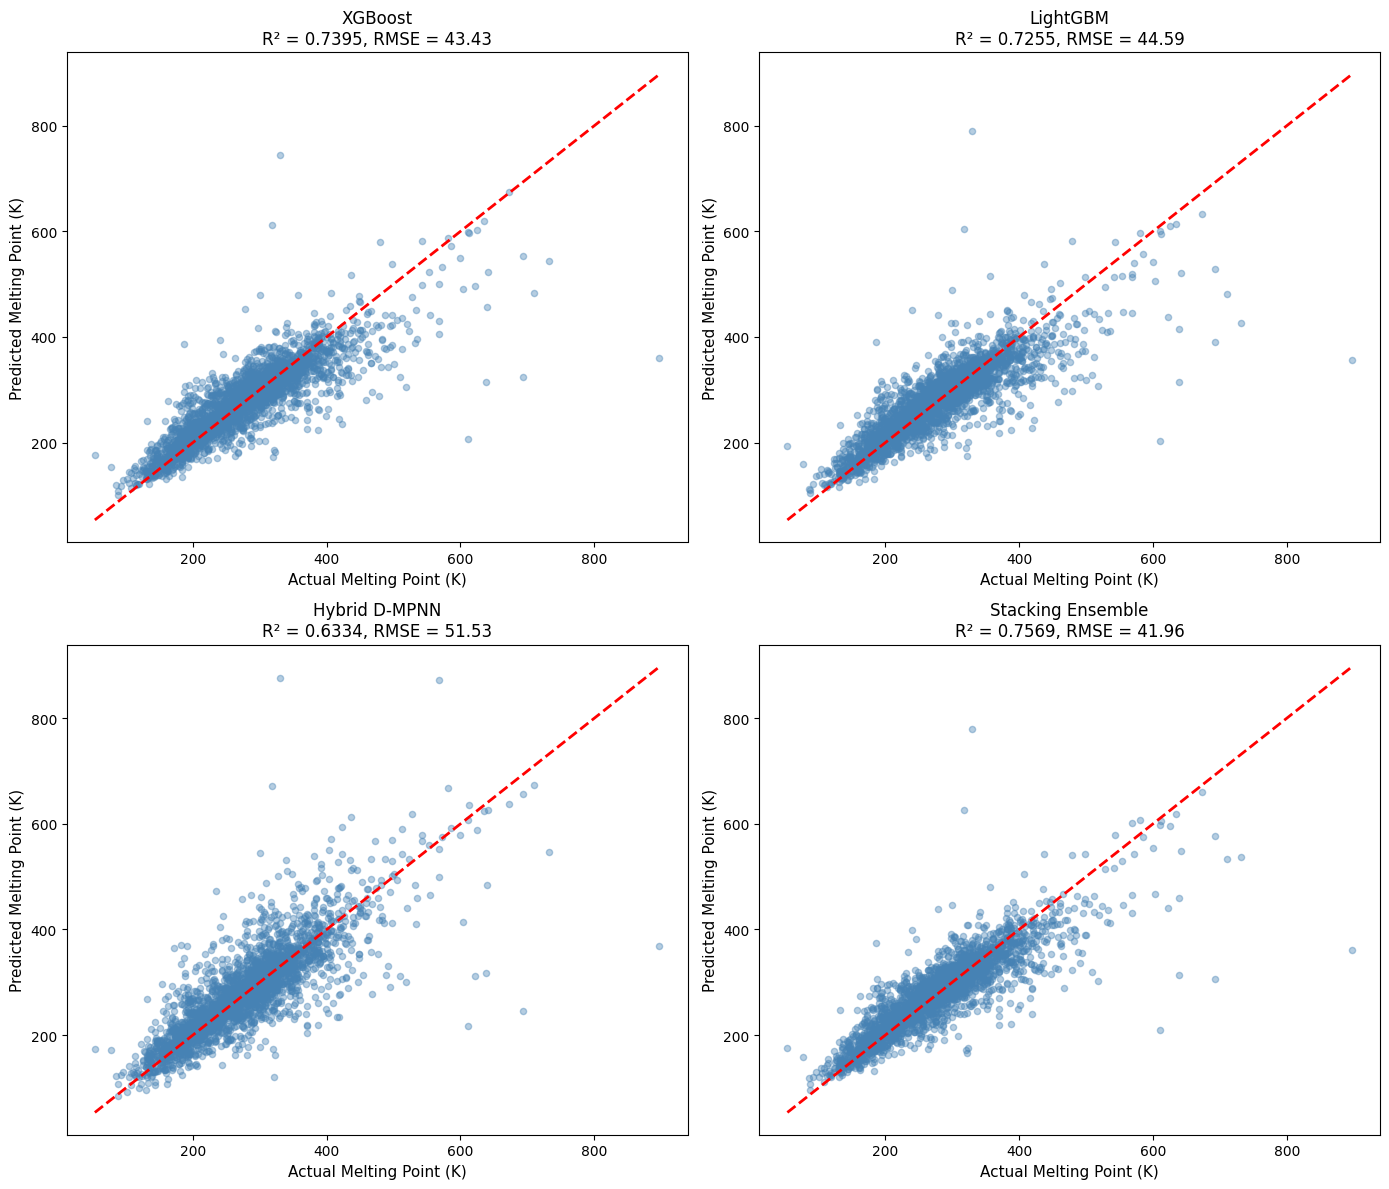

Saved: hybrid_gnn_comparison.png


In [35]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_data = [
    ('XGBoost', xgb_oof_preds, xgb_r2, xgb_rmse),
    ('LightGBM', lgbm_oof_preds, lgbm_r2, lgbm_rmse),
    ('Hybrid D-MPNN', gnn_oof_preds, gnn_oof_r2, gnn_oof_rmse),
    ('Stacking Ensemble', ensemble_oof_preds, ensemble_r2, ensemble_rmse)
]

for ax, (name, preds, r2, rmse) in zip(axes.flat, models_data):
    ax.scatter(y_train, preds, alpha=0.4, s=20, c='steelblue')
    ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', linewidth=2)
    ax.set_xlabel('Actual Melting Point (K)', fontsize=11)
    ax.set_ylabel('Predicted Melting Point (K)', fontsize=11)
    ax.set_title(f'{name}\nR² = {r2:.4f}, RMSE = {rmse:.2f}', fontsize=12)

plt.tight_layout()
plt.savefig('hybrid_gnn_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: hybrid_gnn_comparison.png")

## 11. Generate Test Predictions

In [36]:
print("\n" + "="*60)
print("  GENERATING TEST PREDICTIONS")
print("="*60)

# GNN test predictions (ensemble of fold models)
test_dataset = MoleculeDataset(test_datapoints, featurizer=featurizer)
test_loader = build_dataloader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print("\nGenerating GNN predictions (ensemble of 5 folds)...")
all_gnn_test_preds = []

for fold_num, model in enumerate(fold_models, 1):
    model.eval()
    fold_preds = []
    
    with torch.no_grad():
        for batch in test_loader:
            bmg, V_d, X_d, targets, *_ = batch
            preds = model(bmg, X_d=X_d)  # Pass extra descriptors to model
            fold_preds.extend(preds.squeeze().tolist())
    
    all_gnn_test_preds.append(fold_preds)
    print(f"  Fold {fold_num}: {len(fold_preds)} predictions")

gnn_test_preds = np.mean(all_gnn_test_preds, axis=0)

# Tree model predictions
print("\nGenerating tree model predictions...")
xgb_test_preds = xgb_model.predict(X_test_all)
lgbm_test_preds = lgbm_model.predict(X_test_all)

# Stacking ensemble
stacked_test = np.column_stack([gnn_test_preds, xgb_test_preds, lgbm_test_preds])
ensemble_test_preds = meta_model.predict(stacked_test)

print(f"\nTest predictions statistics:")
print(f"  Hybrid GNN:  Min={gnn_test_preds.min():.1f}, Max={gnn_test_preds.max():.1f}, Mean={gnn_test_preds.mean():.1f}")
print(f"  XGBoost:     Min={xgb_test_preds.min():.1f}, Max={xgb_test_preds.max():.1f}, Mean={xgb_test_preds.mean():.1f}")
print(f"  Ensemble:    Min={ensemble_test_preds.min():.1f}, Max={ensemble_test_preds.max():.1f}, Mean={ensemble_test_preds.mean():.1f}")


  GENERATING TEST PREDICTIONS

Generating GNN predictions (ensemble of 5 folds)...
  Fold 1: 666 predictions
  Fold 2: 666 predictions
  Fold 3: 666 predictions
  Fold 4: 666 predictions
  Fold 5: 666 predictions

Generating tree model predictions...

Test predictions statistics:
  Hybrid GNN:  Min=100.6, Max=660.3, Mean=277.5
  XGBoost:     Min=117.2, Max=629.9, Mean=274.3
  Ensemble:    Min=117.6, Max=628.6, Mean=274.0


In [37]:
# Save submissions
submission_gnn = pd.DataFrame({'id': test_df['id'], 'Tm': gnn_test_preds})
submission_ensemble = pd.DataFrame({'id': test_df['id'], 'Tm': ensemble_test_preds})

submission_gnn.to_csv('submission_hybrid_gnn.csv', index=False)
submission_ensemble.to_csv('submission_stacking_ensemble.csv', index=False)

print("\nSubmissions saved:")
print("  - submission_hybrid_gnn.csv")
print("  - submission_stacking_ensemble.csv")

print("\nEnsemble submission preview:")
print(submission_ensemble.head(10))


Submissions saved:
  - submission_hybrid_gnn.csv
  - submission_stacking_ensemble.csv

Ensemble submission preview:
     id          Tm
0  1022  348.898063
1  1146  319.052955
2    79  204.151646
3  2279  207.365452
4  1342  250.771715
5  2082  341.631846
6    29  247.582714
7   515  302.481757
8  2309  281.905910
9  1177  241.918876


## 12. Final Summary

In [38]:
print("\n" + "="*60)
print("  FINAL SUMMARY")
print("="*60)

print("\nModel Performance (5-Fold CV):")
print("-" * 50)
print(f"{'Model':<25} {'RMSE':<10} {'R²':<10}")
print("-" * 50)
print(f"{'XGBoost (baseline)':<25} {xgb_rmse:<10.2f} {xgb_r2:<10.4f}")
print(f"{'LightGBM':<25} {lgbm_rmse:<10.2f} {lgbm_r2:<10.4f}")
print(f"{'Hybrid D-MPNN':<25} {gnn_oof_rmse:<10.2f} {gnn_oof_r2:<10.4f}")
print(f"{'Stacking Ensemble':<25} {ensemble_rmse:<10.2f} {ensemble_r2:<10.4f}")
print("-" * 50)

print("\nHybrid Approach Details:")
print(f"  - GNN: D-MPNN with hidden_size={CONFIG['hidden_size']}, depth={CONFIG['depth']}")
print(f"  - Extra descriptors: {n_extra_descriptors} (Group + RDKit + Mordred)")
print(f"  - SMILES augmentation: {CONFIG['n_smiles_augment']}x")
print(f"  - Stacking: GNN + XGBoost + LightGBM with Ridge meta-learner")

print("\nFiles generated:")
print("  - submission_hybrid_gnn.csv")
print("  - submission_stacking_ensemble.csv")
print("  - hybrid_gnn_comparison.png")


  FINAL SUMMARY

Model Performance (5-Fold CV):
--------------------------------------------------
Model                     RMSE       R²        
--------------------------------------------------
XGBoost (baseline)        43.43      0.7395    
LightGBM                  44.59      0.7255    
Hybrid D-MPNN             51.53      0.6334    
Stacking Ensemble         41.96      0.7569    
--------------------------------------------------

Hybrid Approach Details:
  - GNN: D-MPNN with hidden_size=600, depth=4
  - Extra descriptors: 1341 (Group + RDKit + Mordred)
  - SMILES augmentation: 5x
  - Stacking: GNN + XGBoost + LightGBM with Ridge meta-learner

Files generated:
  - submission_hybrid_gnn.csv
  - submission_stacking_ensemble.csv
  - hybrid_gnn_comparison.png
